In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
class PartialModel:
    # Assumed that number of actions is same for all states which is true for the machine replacement problem
    def __init__(self, num_states, num_actions, M, quality_interpolation_factor, quality_adjustment_coeff):
        self.num_states = num_states
        self.num_actions = num_actions
        self.T = np.ones((num_actions, num_states, num_states)) / num_states
        self.R = np.zeros((num_actions, num_states))
        self.N = np.zeros((num_actions, num_states))
        self.M = M
        self.quality = 0 # Initial quality
        self.quality_interpolation_factor = quality_interpolation_factor
        self.quality_adjustment_coeff = quality_adjustment_coeff
        self.R_max = 0
        self.R_min = 0

    def update_quality(self, state, action, reward, next_state):
        c = self.N[action, state] / self.M
        delta_R = (reward - self.R[action, state]) / (self.N[action, state] + 1)
        self.R_max = max(self.R_max, self.R[action, state])
        self.R_min = min(self.R_min, self.R[action, state])
        e_R = 1 - 2*delta_R*delta_R/(self.R_max - self.R_min + 1e-5)
        e_T = 1
        for k in range(self.num_states):
            delta_T = (1 - self.T[action, state, k]) / (self.N[action, state] + 1) if k == next_state else -self.T[action, state, k] / (self.N[action, state] + 1)
            e_T -= delta_T*delta_T*self.N[action, state]*self.N[action, state]
        e = c*(self.quality_interpolation_factor*e_R + (1-self.quality_interpolation_factor)*e_T)
        self.quality = (1 - self.quality_adjustment_coeff) * self.quality + self.quality_adjustment_coeff * e


    def update_model(self, state, action, reward, next_state):
        delta_R = (reward - self.R[action, state]) / (self.N[action, state] + 1)
        self.R[action, state] += delta_R

        for k in range(self.num_states):
            delta_T = (1 - self.T[action, state, k]) / (self.N[action, state] + 1) if k == next_state else -self.T[action, state, k] / (self.N[action, state] + 1)
            self.T[action, state, k] += delta_T
        self.N[action, state] = min(self.N[action, state] + 1, self.M)

    def get_quality(self):
        return self.quality

    def get_reward(self, state, action):
        return self.R[action, state]

    def get_next_state(self, state, action):
        return np.random.choice(self.num_states, p=self.T[action, state])

In [18]:
def update_q_values(state, action, reward, next_state, q_values, alpha=0.1, gamma=0.5):
    q_values[state, action] += alpha * (reward + gamma * np.max(q_values[next_state, :]) - q_values[state, action])
    return q_values

In [19]:
class ExperienceBuffer:
    def __init__(self, experiences):
        self.experiences = experiences

    def sample(self):
        if len(self.experiences) == 0:
            return None, None, None, None
        return random.choice(self.experiences)

In [20]:
# implement Dyna for stochastic environments taking maximum simulated sampling iterations as max_simulations
def dyna_stochastic(model, q_values, experiences, num_simulations, max_simulations):
    simulations = 0
    while simulations < max_simulations:
        experience_buffer = ExperienceBuffer(experiences)
        state, action, reward, next_state = experience_buffer.sample()
        if state is None or action is None or reward is None or next_state is None:
            break
        q_values = update_q_values(state, action, reward, next_state, q_values)   # direct RL
        # model.update_model(state, action, reward, next_state)
        # model.update_quality(state, action, reward, next_state)

        for _ in range(num_simulations):
            simulated_state = np.random.choice(model.num_states, p=model.T[action, state])
            simulated_action = np.random.choice(model.num_actions)
            simulated_reward = model.get_reward(simulated_state, action)
            simulated_next_state = model.get_next_state(simulated_state, action)

            q_values = update_q_values(simulated_state, simulated_action, simulated_reward, simulated_next_state, q_values)   # direct RL

        simulations += 1

    return simulations, q_values

# RLCD on Machine Replacement

In [21]:
# set total number of states and define a transition probability matrix of that size
num_states = 10
num_actions = 2
replacement_cost = 50
num_changes = 2
transition_probabilities = np.zeros((num_changes + 1, 2, num_states, num_states))
max_restarts = 10
epsilon = 1

In [22]:
def maintenance_cost(state):
    return state**2 + state

def cost_function(state, action, replacement_cost, post_change=False):
    if action == 0:
        return replacement_cost + maintenance_cost(0)
    else:
        if post_change:
            return maintenance_cost_post_change(state)
        return maintenance_cost(state)

def maintenance_cost_post_change(state):
    return  - state**2 + state

In [23]:
def fill_transition_probability_matrix(transition_probability, p=0.5):
    for j in range(transition_probability.shape[1]-1):
        transition_probability[1][j][j] = p
        transition_probability[1][j][j+1] = 1-p
    for i in range(transition_probability.shape[1]):
        for j in range(transition_probability.shape[2]):
            transition_probability[0][i][j] = transition_probability[1][0][j]
    transition_probability[1, transition_probability.shape[1]-1, transition_probability.shape[1]-1] = 1

In [24]:
def policy_visualization(policy):
    plt.bar(range(num_states), policy)
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.show()

In [25]:
fill_transition_probability_matrix(transition_probabilities[0], p=0.2)
fill_transition_probability_matrix(transition_probabilities[1], p=0.8)
transition_probabilities[2] = transition_probabilities[0].copy()
print("Transition Probability Matrix:")
print(transition_probabilities)

Transition Probability Matrix:
[[[[0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]]

  [[0.2 0.8 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.  0.2 0.8 0.  0.  0.  0.  0.  0.  0. ]
   [0.  0.  0.2 0.8 0.  0.  0.  0.  0.  0. ]
   [0.  0.  0.  0.2 0.8 0.  0.  0.  0.  0. ]
   [0.  0.  0.  0.  0.2 0.8 0.  0.  0.  0. ]
   [0.  0.  0.  0.  0.  0.2 0.8 0.  0.  0. ]
   [0.  0.  0.  0.  0.  0.  0.2 0.8 0.  0. ]
   [0.  0.  0.  0.  0.  0.  0.  0.2 0.8 0. ]
   [0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.8]
   [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]]


 [[[0.8 0.2 0.  0.  0.  0.  0.  0.  0.  0. ]
   [0.8 0.2 0.  0.

In [26]:
C = [[[cost_function(state, action, replacement_cost) for state in range(num_states)] for action in range(2)]]

C.append([[cost_function(state, action, replacement_cost, post_change=True) for state in range(num_states)] for action in range(2)])
# C.append([[cost_function(state, action, replacement_cost) for state in range(num_states)] for action in range(2)])
C.append([[cost_function(state, action, replacement_cost) for state in range(num_states)] for action in range(2)])

C = np.array(C)

C

array([[[ 50,  50,  50,  50,  50,  50,  50,  50,  50,  50],
        [  0,   2,   6,  12,  20,  30,  42,  56,  72,  90]],

       [[ 50,  50,  50,  50,  50,  50,  50,  50,  50,  50],
        [  0,   0,  -2,  -6, -12, -20, -30, -42, -56, -72]],

       [[ 50,  50,  50,  50,  50,  50,  50,  50,  50,  50],
        [  0,   2,   6,  12,  20,  30,  42,  56,  72,  90]]])

In [27]:
def T(R, P, V, alpha=0.5):
    return R + alpha* (P @ V)

In [28]:
class MachineReplacementEnv:
    def __init__(self, num_states, num_actions, cost_function, pre_change_tpm, post_change_tpm, env_change):
        self.num_states = num_states
        self.num_actions = num_actions
        self.cost_function = cost_function
        self.pre_change_tpm = pre_change_tpm
        self.post_change_tpm = post_change_tpm
        self.q_values = np.zeros((num_states, num_actions))
        self.env_change = env_change
        self.state = np.random.randint(num_states)

    def reset(self):
        self.state = np.random.randint(self.num_states)
        return self.state

    def step(self, action):
        # if action == 0: # replace machine
        #     if not self.env_change:
        #         next_state = np.random.choice(self.num_states, p=self.pre_change_tpm[action, self.state, :])
        #     else:
        #         next_state = np.random.choice(self.num_states, p=self.post_change_tpm[action, self.state, :])
        #     reward = self.cost_function[action][self.state]
        # else: # do not replace machine
        #     if not self.env_change:
        #         next_state = np.random.choice(self.num_states, p=self.pre_change_tpm[action, self.state, :])
        #     else:
        #         next_state = np.random.choice(self.num_states, p=self.post_change_tpm[action, self.state, :])
        #     reward = self.cost_function[action][self.state]

        # exp_tuple = (self.state, action, reward, next_state)
        # self.state = next_state
        # return next_state, reward, exp_tuple

        if not self.env_change:
            next_state = np.random.choice(self.num_states, p=self.pre_change_tpm[action, self.state, :])
        else:
            next_state = np.random.choice(self.num_states, p=self.post_change_tpm[action, self.state, :])
        reward = self.cost_function[action][self.state]
        exp_tuple = (self.state, action, reward, next_state)
        self.state = next_state
        return next_state, reward, exp_tuple


In [29]:
env = MachineReplacementEnv(num_states, num_actions, C[0], transition_probabilities[0], transition_probabilities[1], env_change=False)

In [30]:
# RLCD on Machine Replacement
m_curr = PartialModel(num_states, num_actions, M=100, quality_interpolation_factor=0.5, quality_adjustment_coeff=0.1)
M_models = [m_curr]
q_values = np.zeros((num_states, num_actions))
E_min = -0.5 # needs tuning, with current scenario, might have to take average over a couple episodes to get a switch after a change in environment
max_steps = 1000
experience_tuples = []
q_values_history = []
best_model_quality = []

for i in tqdm(range(max_restarts)):
    if i == 5:
        env = MachineReplacementEnv(num_states, num_actions, C[1], transition_probabilities[0], transition_probabilities[1], env_change=True)
        epsilon = 1
    state = env.reset()
    for step in range(max_steps):
        if np.random.rand() < epsilon:
            action = np.random.choice(num_actions)
        else:
            action = np.argmin(q_values[state, :])

        next_state, reward, experience = env.step(action)
        experience_tuples.append(experience)

        exp_state, exp_action, exp_reward, exp_next_state = experience

        for m in M_models:
            m.update_model(exp_state, exp_action, exp_reward, exp_next_state)
            m.update_quality(exp_state, exp_action, exp_reward, exp_next_state)

        m_best = max(M_models, key=lambda m: m.get_quality())
        best_model_quality.append(m_best.get_quality())

        if m_best.get_quality() < E_min:
            print(f"Creating new model at restart {i}, step {step} with quality {m_best.get_quality()} due to change in environment")
            m_curr = PartialModel(num_states, num_actions, M=100, quality_interpolation_factor=0.5, quality_adjustment_coeff=0.1)
            M_models.append(m_curr)
        else:
            m_curr = m_best

        m_curr.update_model(exp_state, exp_action, exp_reward, exp_next_state)
        m_curr.update_quality(exp_state, exp_action, exp_reward, exp_next_state)
        m_curr.N[exp_action, exp_state] = min(m_curr.N[exp_action, exp_state] + 1, m_curr.M)

        num_simulations = 10
        _, q_values = dyna_stochastic(m_curr, q_values, experience_tuples, num_simulations=num_simulations, max_simulations=100)
        q_values_history.append(q_values.copy())
        state = next_state

        epsilon = max(0.1, epsilon * 0.99)  # Decay epsilon


100%|██████████| 10/10 [02:54<00:00, 17.47s/it]


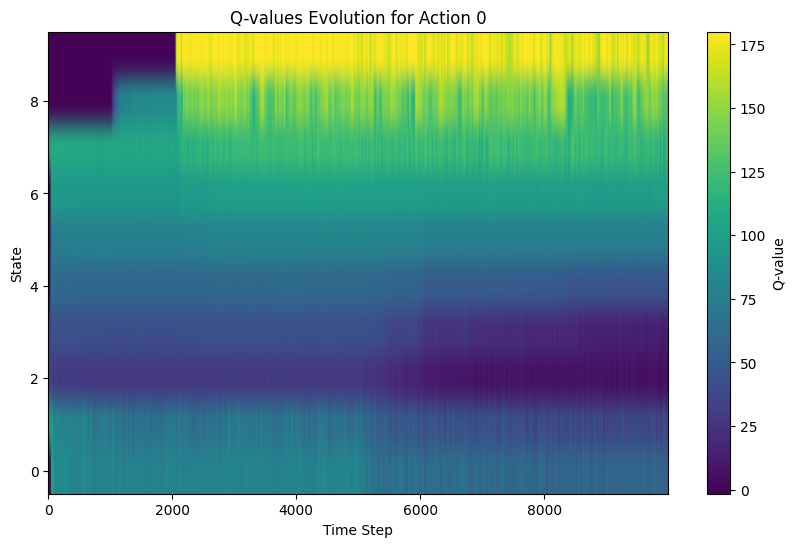

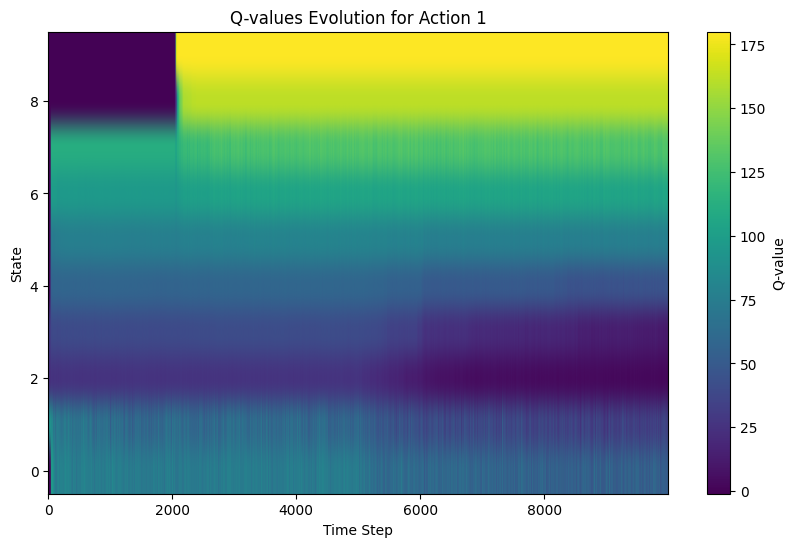

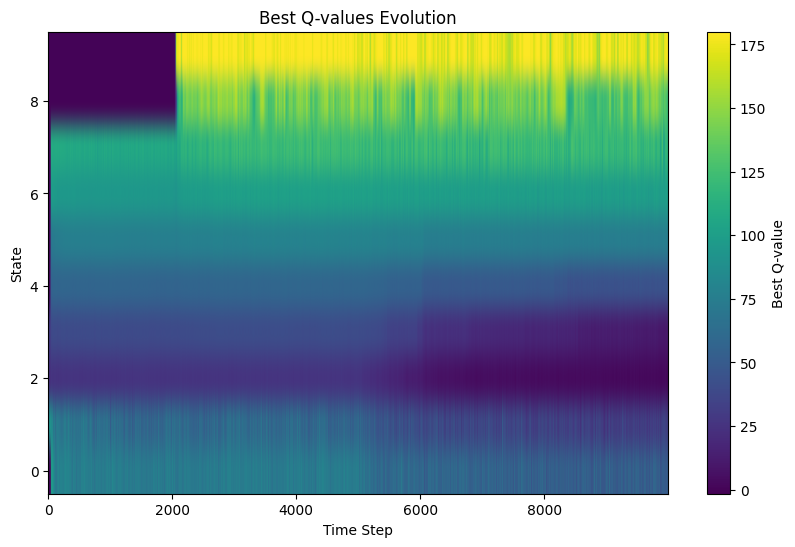

In [31]:
# Convert q_values_history to numpy array for easier plotting
q_values_history = np.array(q_values_history)  # Shape: (num_time_steps, num_states, num_actions)

# Plot Q-values evolution as a heatmap for each action
for action in range(q_values_history.shape[2]):
    plt.figure(figsize=(10, 6))
    plt.imshow(q_values_history[:, :, action].T, aspect='auto', cmap='viridis', origin='lower')
    plt.colorbar(label='Q-value')
    plt.xlabel('Time Step')
    plt.ylabel('State')
    plt.title(f'Q-values Evolution for Action {action}')
    plt.show()

best_q_values = np.min(q_values_history, axis=2)  # Get the best Q-values across actions for each state
plt.figure(figsize=(10, 6))
plt.imshow(best_q_values.T, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Best Q-value')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.title('Best Q-values Evolution')
plt.show()

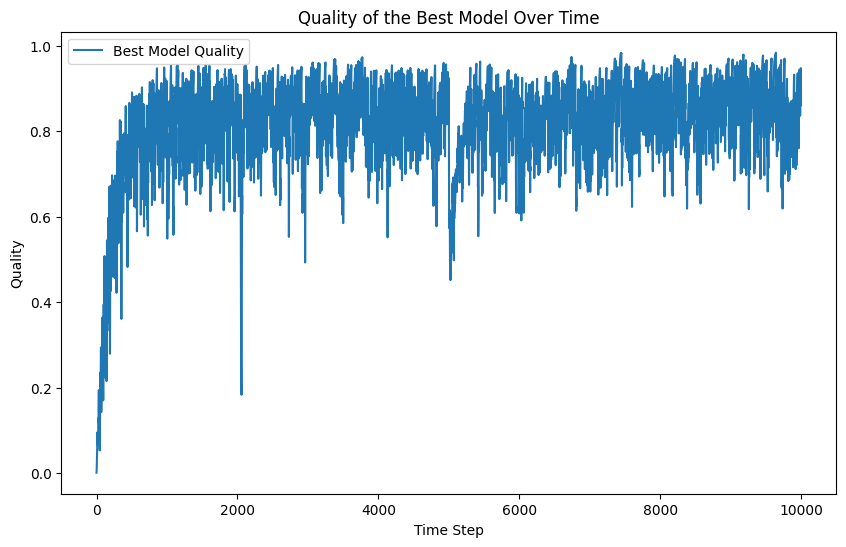

In [32]:
# plotting the quality of the best model over time
plt.figure(figsize=(10, 6))
plt.plot(best_model_quality, label='Best Model Quality')
plt.xlabel('Time Step')
plt.ylabel('Quality')
plt.title('Quality of the Best Model Over Time')
plt.legend()
plt.show()